# Acha buracos em sementes

In [60]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon

def para_poligonos(input_image):
	return measure.find_contours(input_image, 200)

def remove_fundo(input_image):
	used_threshold, thresholded_bgr_image = cv2.threshold(input_image, 110, 255, cv2.THRESH_BINARY)
	thresholded_blue_component, thresholded_green_component, thresholded_red_component = cv2.split(thresholded_bgr_image)

	mask_filtered = cv2.medianBlur(thresholded_red_component, ksize=5)

	return mask_filtered

def alinhar(imagem_original):
	"""Funcao que recebe uma imagem de malha com sementes
	e retorna uma imagem com a malha alinhada.
	"""
	
	# Tamanho da imagem
	[x, y, z] = np.shape(imagem_original)

	# Faz a segmentacao com thresholding
	(T, imagem_thresh) = cv2.threshold(imagem_original, 115, 255, cv2.THRESH_BINARY)

	# Deixa a imagem em escala de cinza
	imagem_cinza = cv2.cvtColor(imagem_thresh, cv2.COLOR_BGR2GRAY)

	# Prepara para alinhamento
	# Ponto de busca da borda da malha situado no hemisferio norte da imagem
	ponto_busca1 = [int(x*(1/3)), int(y*(1/10))]

	# Ponto situado no hemisferio sul da imagem
	ponto_busca2 = [int(x*(2/3)), int(y*(1/10))]

	# Move o ponto de busca 1 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_busca1[0], ponto_busca1[1]] == 0):
			# Sai do loop com coordenada x na borda da malha
			break
		# Caso pixel nao possua o valor desejado
		ponto_busca1[1] = ponto_busca1[1] + 1

	# Move o ponto de busca 2 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_busca2[0], ponto_busca2[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

	    # Caso pixel nao possua o valor desejado
		ponto_busca2[1] = ponto_busca2[1] + 1


	
	# Calculo do angulo de rotacao utilizando trigonometria
	L1 = ponto_busca2[0] - ponto_busca1[0] # Cateto adjacente
	L2 = ponto_busca2[1] - ponto_busca1[1] # Cateto oposto
	angulo = np.arctan(L2/L1)
	angulo = np.rad2deg(angulo)

	# Rotaciona a imagem
	imagem_rot = imutils.rotate(imagem_original, -angulo)
	
	return imagem_rot


def cortar_malha(imagem_original):
	"""Funcao que recebe uma imagem de malha com sementes
	e retorna um vetor com 50 sementes individuais.
	"""

	# Alinha a imagem
	imagem_alinhada = alinhar(imagem_original)

	# Tamanho da imagem
	[x, y, z] = np.shape(imagem_alinhada)

	# Faz a segmentacao com thresholding
	(T, imagem_thresh) = cv2.threshold(imagem_alinhada, 115, 255, cv2.THRESH_BINARY)

	# Deixa a imagem em escala de cinza
	imagem_cinza = cv2.cvtColor(imagem_thresh, cv2.COLOR_BGR2GRAY)

	# Prepara para corte
	# Ponto de busca da borda da malha situado no lado esquerdo da imagem
	ponto_medio1 = [int(x*(1/2)), int(y*(1/10))]

	# Ponto situado no lado direito da imagem
	ponto_medio2 = [int(x*(1/2)), int(y*(9.5/10))]

	# Ponto situado na parte inferior da imagem
	ponto_medio3 = [int(x*0.96866), int(y*(1/2))]

	# Ponto situado na parte superior da imagem
	ponto_medio4 = [int(x*0.03134), int(y*(1/2))]

	# Move o ponto de busca 1 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio1[0], ponto_medio1[1]] == 0):
			# Sai do loop com coordenada y na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio1[1] = ponto_medio1[1] + 1
		
	# Move o ponto de busca 2 a esquerda ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio2[0], ponto_medio2[1]] == 0):
			# Sai do loop com coordenada y na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio2[1] = ponto_medio2[1] - 1

	# Move o ponto de busca 3 para cima ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio3[0], ponto_medio3[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio3[0] = ponto_medio3[0] - 1
		
	# Move o ponto de busca 4 para baixo ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio4[0], ponto_medio4[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio4[0] = ponto_medio4[0] + 1
		
	# Coordenadas do vertice inferior esquerdo da malha
	coords1 = [ponto_medio3[0], ponto_medio1[1]]
	coords2 = [ponto_medio3[0], ponto_medio2[1]]
	y_inicial = coords1[1]

	# Medidas aproximadas dos lados das secoes
	comp_malha = coords2[1] - coords1[1]		# Comprimento da malha
	lado_comp = int(comp_malha/5)			# Comprimento da secao
	alt_malha = ponto_medio3[0] - ponto_medio4[0]	# Altura da malha
	lado_alt = int(alt_malha/10)			# Altura da secao

	# Define vetor onde sera armazenada cada semente
	semente = []

	# Popula o vetor com as sementes adequadas, sendo semente[0] a semente 1
	for i in range(10):
		for j in range(5):
			semente.append(imagem_alinhada[(coords1[0] - lado_alt):coords1[0], coords1[1]:(coords1[1] + lado_comp)])
			coords1[1] = coords1[1] + lado_comp
		# Prepara para obter as imagens das sementes da linha acima
		coords1[1] = y_inicial
		coords1[0] = coords1[0] - lado_alt
		
	return semente

(0.0, 256.0)

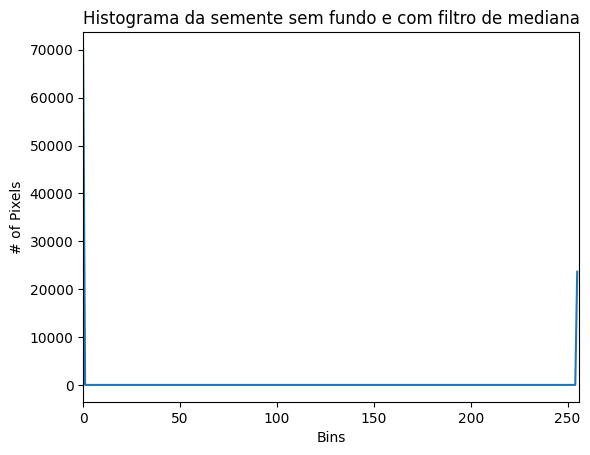

In [55]:
target = './LOTE 2 R2 INTERNA.jpeg'

input_image = cv2.imread(target)

scale_percent = 25
width = int(input_image.shape[1] * scale_percent / 100)
height = int(input_image.shape[0] * scale_percent / 100)
dim = (width, height)

# plt.imshow(cv2.resize(input_image, dim, interpolation = cv2.INTER_AREA))

seeds = cortar_malha(input_image)


seed = seeds[0]
thresholded_red_component = remove_fundo(seed)



hist = cv2.calcHist([thresholded_red_component],[0],None,[256],[0,256])
plt.figure()
plt.title("Histograma da semente sem fundo e com filtro de mediana")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])


Quantiade: 1
Porcentagem: 0.000491


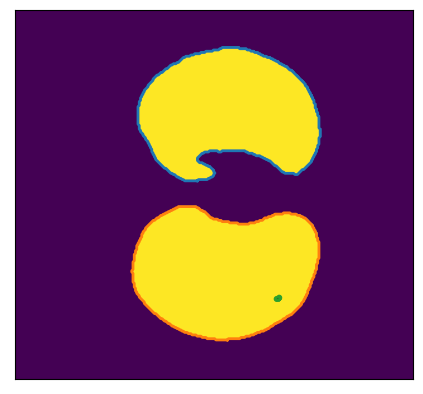

Quantiade: 0
Porcentagem: 0.000000


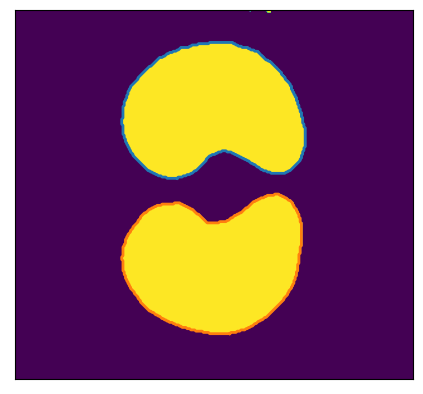

Quantiade: 0
Porcentagem: 0.000000


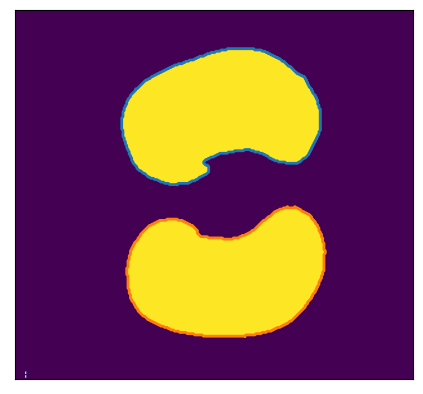

Quantiade: 1
Porcentagem: 0.000516


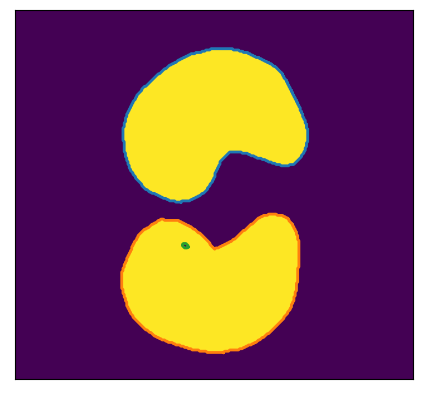

Quantiade: 1
Porcentagem: 0.001564


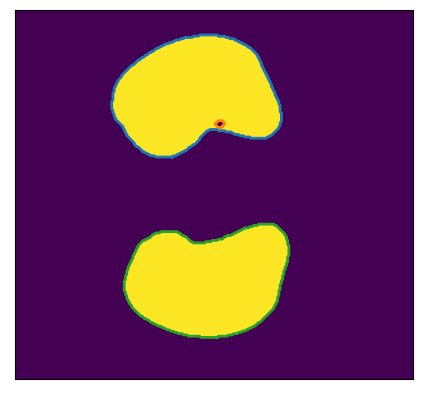

Quantiade: 1
Porcentagem: 0.000604


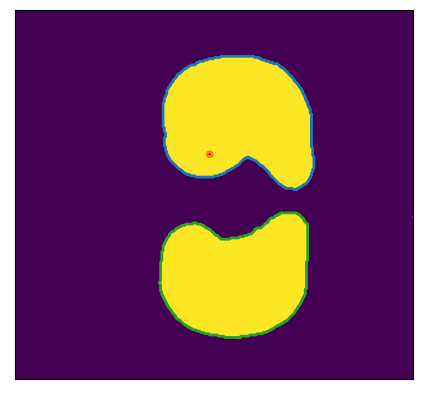

Quantiade: 0
Porcentagem: 0.000000


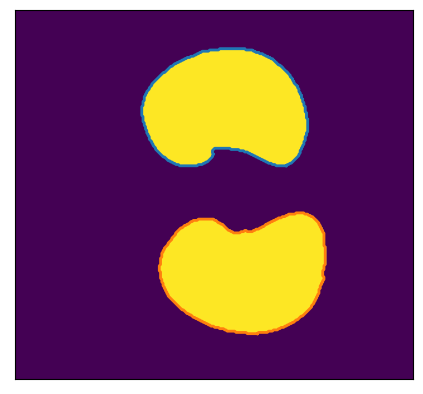

Quantiade: 0
Porcentagem: 0.000000


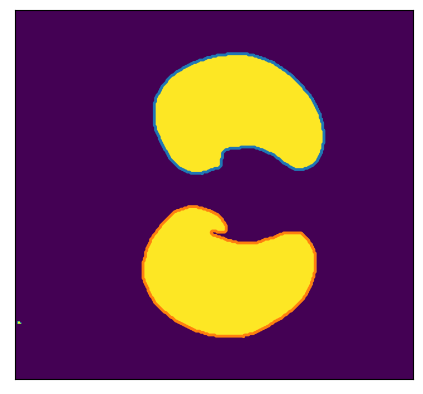

Quantiade: 0
Porcentagem: 0.000000


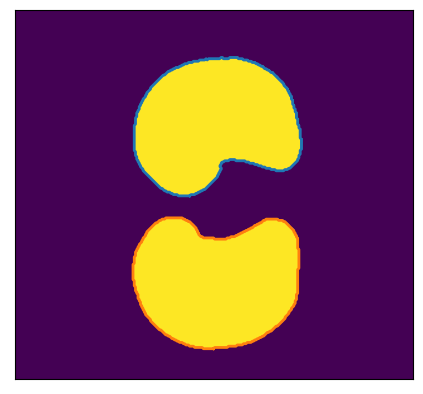

Quantiade: 2
Porcentagem: 0.002706


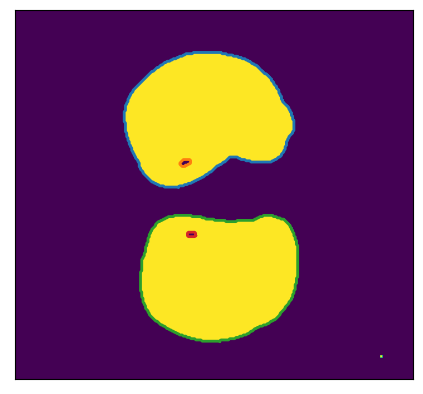

Quantiade: 0
Porcentagem: 0.000000


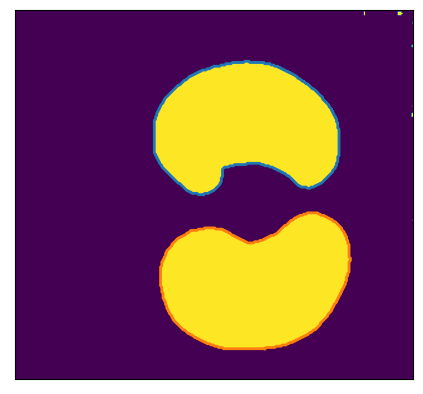

Quantiade: 0
Porcentagem: 0.000000


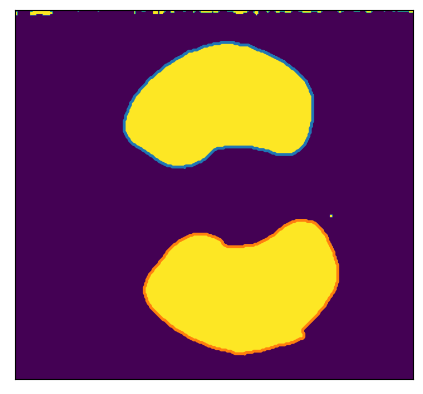

Quantiade: 0
Porcentagem: 0.000000


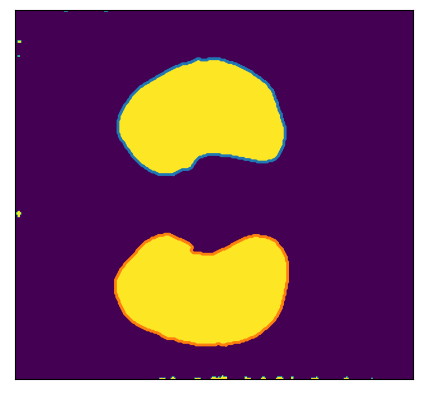

Quantiade: 0
Porcentagem: 0.000000


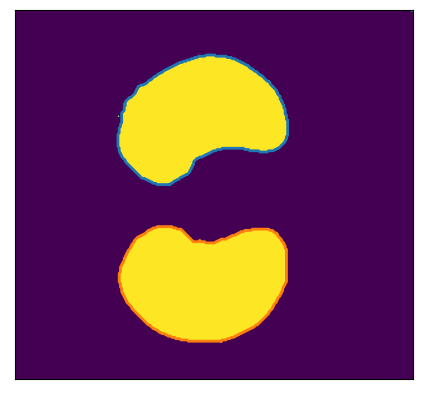

Quantiade: 0
Porcentagem: 0.000000


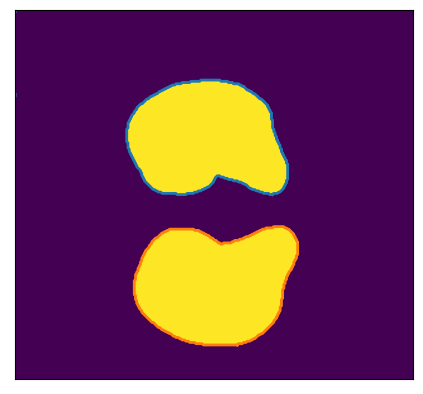

Quantiade: 0
Porcentagem: 0.000000


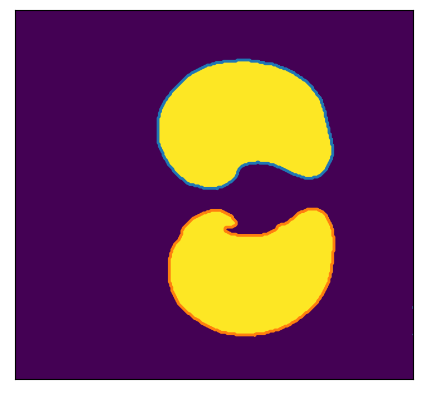

Quantiade: 0
Porcentagem: 0.000000


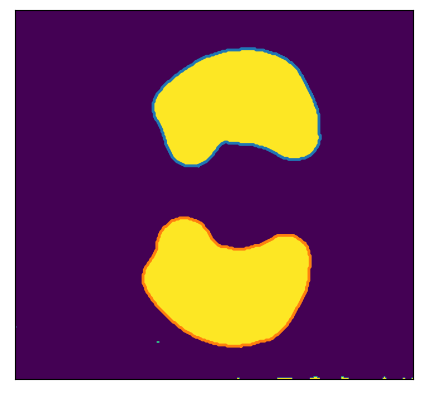

Quantiade: 0
Porcentagem: 0.000000


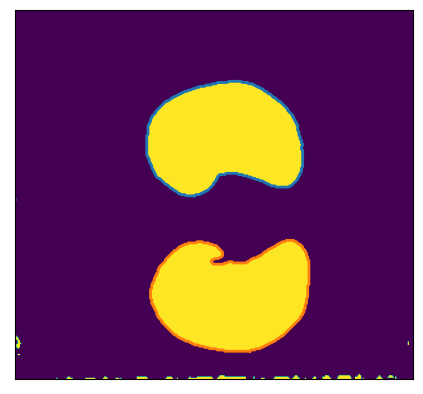

Quantiade: 0
Porcentagem: 0.000000


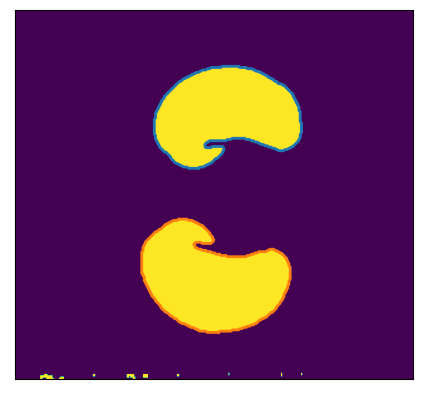

Quantiade: 0
Porcentagem: 0.000000


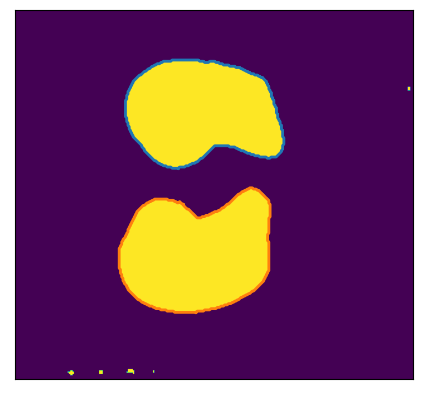

Quantiade: 0
Porcentagem: 0.000000


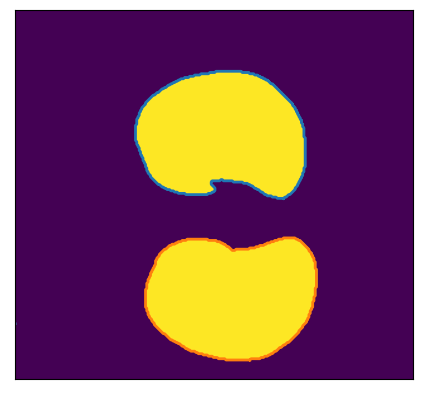

Quantiade: 1
Porcentagem: 0.000765


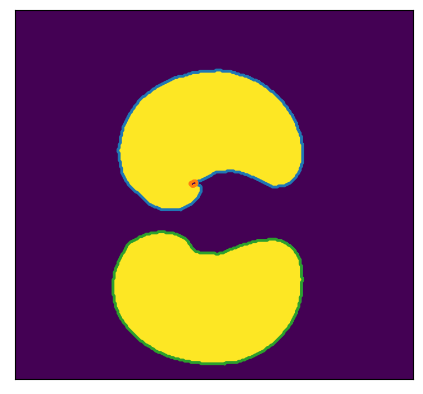

Quantiade: 0
Porcentagem: 0.000000


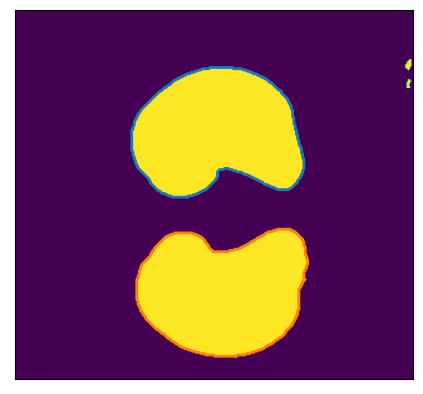

Quantiade: 1
Porcentagem: 0.069599


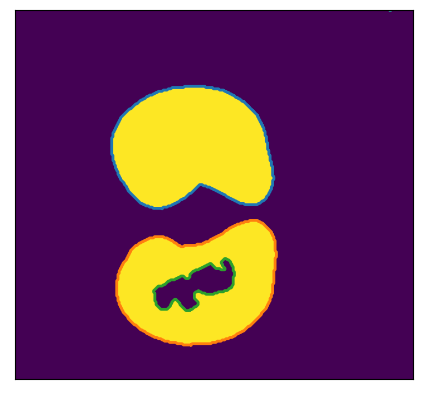

In [88]:
i = 1
for seed in seeds:
    thresholded_red_component = remove_fundo(seed)

    contours = para_poligonos(thresholded_red_component)
    holes = [Polygon(contour) for contour in contours if len(contour) > 3]
    
    seed_polygons = []
    
    #ordenando pela maior área (as duas maiores áreas são os próprio feijão)
    holes.sort(reverse=True, key=lambda element: element.area)

    within = [] 
    up = 0
    down = 0    
    

    # checando se tem buracos
    if len(holes) > 2:
        for i in range(2):
            seed_polygons.append(holes[i])
            down += holes[i].area
            

        holes.pop(0)
        holes.pop(0)

        for hole in holes:
            contained = False
            for seed_polygon in seed_polygons:
                if hole.within(seed_polygon):
                    within.append(hole)
                    up += hole.area
                

        fig, ax = plt.subplots()
        ax.imshow(thresholded_red_component)


        for contour in contours:
            if len(contour) < 3:
                continue

            pol = Polygon(contour)
            if seed_polygons.count(pol) != 0 or within.count(pol) != 0:
                ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

        print(f"Quantiade: {len(within)}")
        print(f"Porcentagem: {(up/down):.6f}")
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()

    plt.close()

    